In [1]:
format(Sys.time(), tz = "Asia/Tokyo", usetz = TRUE)

[1] "2025-08-27 13:26:39 JST"

# Environment

In [2]:
library(Seurat)
library(patchwork)
library(tidyverse) 

library(SingleR)
library(celldex)
library(SingleCellExperiment)

set.seed(1234)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following objects are masked from ‘package:base’:

    intersect, t


── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

In [3]:
sessionInfo()

R version 4.4.1 (2024-06-14)
Platform: x86_64-pc-linux-gnu
Running under: Ubuntu 22.04.5 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/atlas/libblas.so.3.10.3 
LAPACK: /usr/lib/x86_64-linux-gnu/atlas/liblapack.so.3.10.3;  LAPACK version 3.10.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] SingleCellExperiment_1.26.0 celldex_1.14.0             
 [3] SingleR_2.6.0               SummarizedExperiment_1.34.0
 [5] Biobase_2.64.0              GenomicRanges_1.56.2       
 [7] GenomeInfoDb_1.40.1         IRanges_2.38.1             


# Data

In [4]:
merged <- readRDS("../../results/sc_rna/06_01_overall/intermediate/06_annotation/merged_pca.rds")

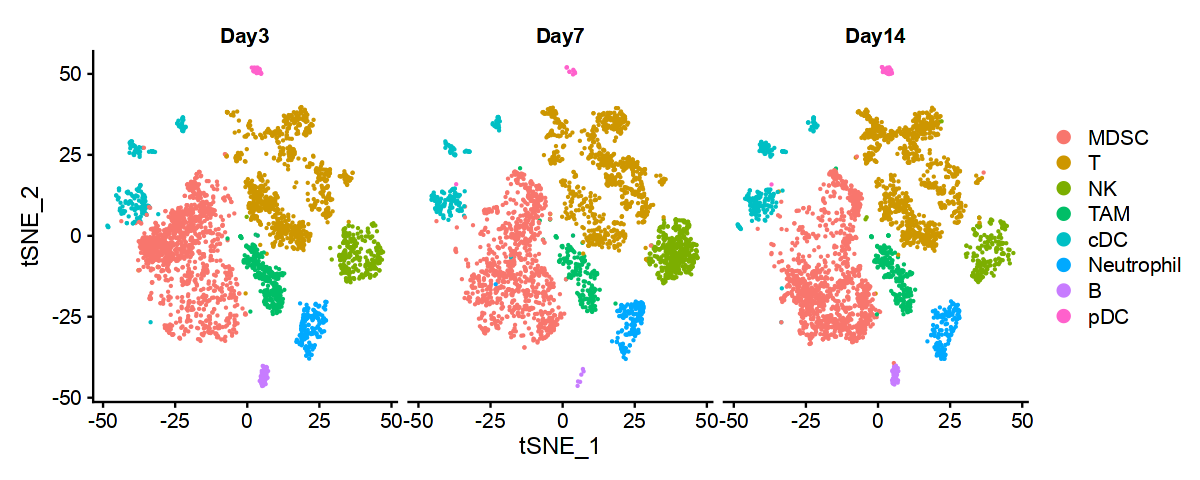

In [5]:
options(repr.plot.width = 10, repr.plot.height = 4)
DimPlot(merged, reduction = "tsne", split.by='day')

In [6]:
levels(merged)

[1] "MDSC"       "T"          "NK"         "TAM"        "cDC"       
[6] "Neutrophil" "B"          "pDC"

reference code: https://erilu.github.io/single-cell-rnaseq-analysis/

In [7]:
get_GSEA_ranked_list <- function(seuratobj, cell_type, set1, set2, output_file) {
  # Add meta data
  seuratobj[["group"]] <- recode(seuratobj@meta.data$orig.ident, "day03" = "Day3", "day07" = "Day7", "day14" = "Day14")
  
  # Subset the specified cell type
  cell_subset <- subset(seuratobj, idents = cell_type)
  cell_subset <- SetIdent(cell_subset, value = "group")  # Set the group information (Day3, Day7, Day14) as the active identity

  # DEG analysis
  ranked_list <- FindMarkers(cell_subset, ident.1 = set1, ident.2 = set2, min.pct = 0.1, logfc.threshold = 0)

  # Sort by log fold change (descending order)
  ranked_list <- ranked_list[order(ranked_list$avg_log2FC, decreasing = TRUE),]
  
  # Add gene names and select relevant columns
  ranked_list$Gene.name <- rownames(ranked_list)
  ranked_list <- ranked_list[,c("Gene.name", "avg_log2FC")]
  rownames(ranked_list) <- NULL

  # Save as `.rnk` file for GSEA input
  write.table(ranked_list, file = output_file, sep = "\t", row.names = F, quote = F)
}

In [8]:
prepare_ranked_list <- function(ranked_list) { 
  # if duplicate gene names present, average the values
  if( sum(duplicated(ranked_list$Gene.name)) > 0) {
    ranked_list <- aggregate(.~Gene.name, FUN = mean, data = ranked_list)
    ranked_list <- ranked_list[order(ranked_list$avg_logFC, decreasing = T),]
  }
  # omit rows with NA values
  ranked_list <- na.omit(ranked_list)
  # turn the dataframe into a named vector
  ranked_list <- tibble::deframe(ranked_list)
  ranked_list
}

# Analysis

In [9]:
out_dir     <- "../../results/sc_rna/06_03_GSEA"
dir.create(out_dir, showWarnings = FALSE, recursive = TRUE)

In [10]:
comparisons <- list(
  c("Day3", "Day7"),
  c("Day7", "Day14"),
  c("Day3", "Day14")
)

In [11]:
#cell_types  <- c('MDSC', 'T', 'NK', 'TAM', 'cDC', 'Neutrophil', 'B', 'pDC')
cell_types  <- c('MDSC')
out_dir_rnk <- file.path(out_dir, "rnk")

dir.create(out_dir_rnk, recursive=TRUE, showWarnings=FALSE)

for (ct in cell_types) {
  for (cmp in comparisons) {
    set1 <- cmp[1];  set2 <- cmp[2]
    fname <- sprintf("%s_%s_vs_%s_ranked.rnk", ct, set1, set2)
    get_GSEA_ranked_list(
      seuratobj   = merged,
      cell_type   = ct,
      set1        = set1,
      set2        = set2,
      output_file = file.path(out_dir_rnk, fname)
    )
  }
}

In [12]:
# Load MSigDB Hallmark pathways (mouse symbols)
library(fgsea)
hallmark_pathway <- gmtPathways("../../data/pathway_files/mh.all.v2025.1.Mm.symbols.gmt")


fgsea_results_list <- list()

for (ct in cell_types) {
  for (cmp in comparisons) {
    set1 <- cmp[1]; set2 <- cmp[2]
    key <- sprintf("%s_%s_vs_%s", ct, set1, set2)
    
    cat(">> Now processing:", key, "\n")
    
    rnk_file <- file.path(out_dir_rnk,
                  sprintf("%s_%s_vs_%s_ranked.rnk", ct, set1, set2))

    # Read '.rnk' file
    df_rnk <- read.table(rnk_file, sep="\t", header=TRUE, stringsAsFactors=FALSE)
    stats   <- prepare_ranked_list(df_rnk)
    
    # fgsea
    res <- fgseaMultilevel(
      pathways = hallmark_pathway,
      stats    = stats,
      minSize  = 15,
      maxSize  = 500
    )
    
    # Keep the most interpretable columns and sort by NES (descending)
    fgsea_results_list[[key]] <- res %>%
      arrange(desc(NES)) %>%
      dplyr::select(pathway, NES, padj)
  }
}

>> Now processing: MDSC_Day3_vs_Day7 
>> Now processing: MDSC_Day7_vs_Day14 
>> Now processing: MDSC_Day3_vs_Day14 


In [13]:
plot_enrichment <- function (geneset, pathway, ranked_list) {
  plotEnrichment(geneset[[pathway]], ranked_list)+labs (title = pathway)
}

waterfall_plot <- function (fgsea_results, graph_title) {
  fgsea_results %>% 
    mutate(short_name = str_split_fixed(pathway, "_",2)[,2])%>%
    ggplot( aes(reorder(short_name,NES), NES)) +
      geom_bar(stat= "identity", aes(fill = padj<0.05))+
      coord_flip()+
      labs(x = "Hallmark Pathway", y = "Normalized Enrichment Score", title = graph_title)+
      theme(axis.text.y = element_text(size = 12), 
            plot.title = element_text(hjust = 1))
}

In [14]:
out_dir_jpeg <- file.path(out_dir, "waterfall")
dir.create(out_dir_jpeg, showWarnings = FALSE, recursive = TRUE)

# Generate waterfall plots
for (key in names(fgsea_results_list)) {
  p <- waterfall_plot(fgsea_results_list[[key]], graph_title = key)
  
  # Filename（.jpeg）
  file_jpeg <- file.path(out_dir_jpeg, paste0(key, ".jpeg"))
  
  # Save
  ggsave(filename = file_jpeg, plot = p, device = "jpeg", width = 8, height = 8, dpi = 500)
  ggsave(filename = file_jpeg, plot = p, device = "pdf", width = 8, height = 8, dpi = 500)
}

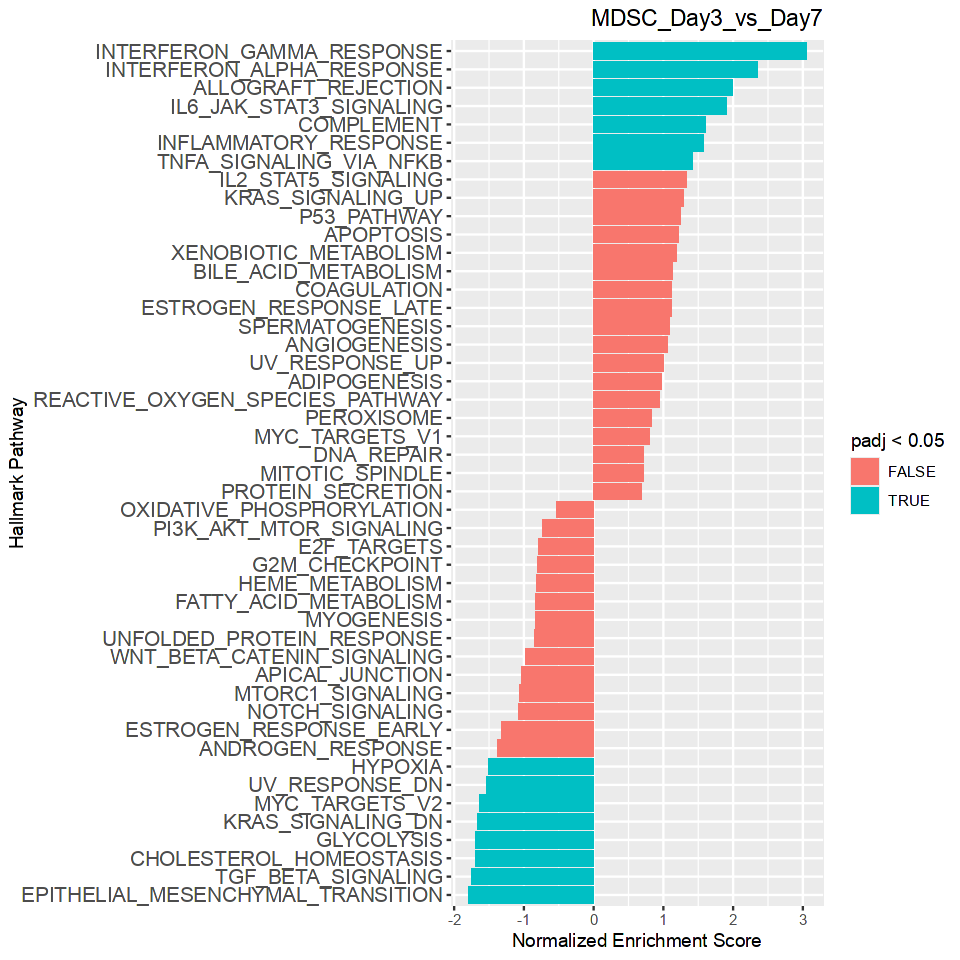

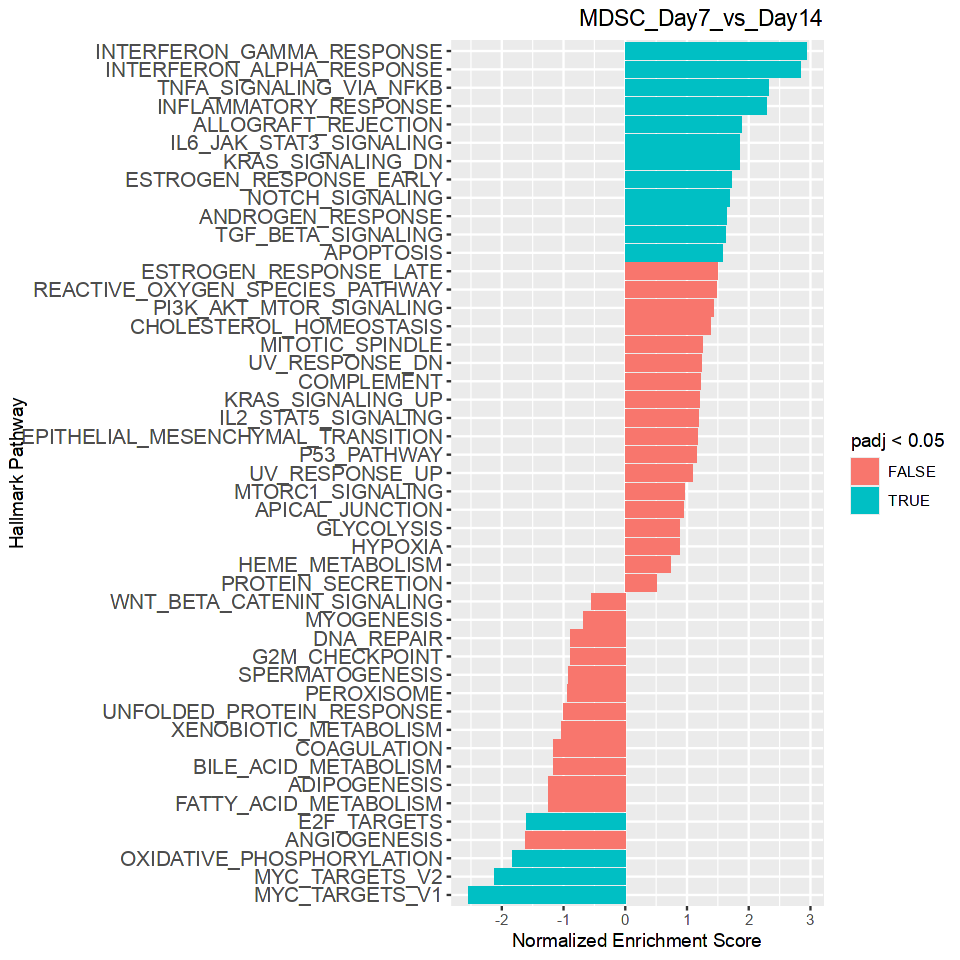

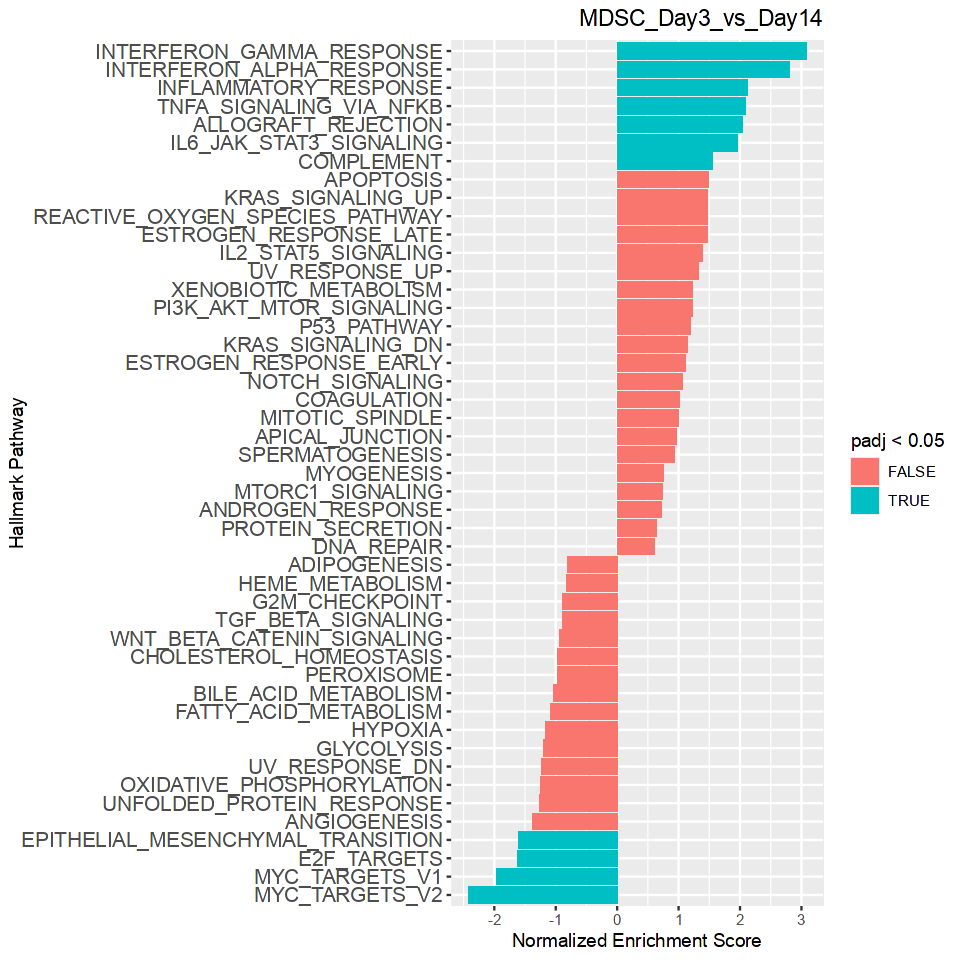

In [15]:
options(repr.plot.width = 8, repr.plot.height = 8)

# Specify target cell types to visualize
target_cts <- c("MDSC")

# Filter keys in fgsea_results_list that match the target cell types
keys_to_plot <- names(fgsea_results_list)[
  grepl(paste0("^(", paste(target_cts, collapse="|"), ")_"), names(fgsea_results_list))
]

# Generate and display waterfall plots for the selected comparisons
for (key in keys_to_plot) {
  p <- waterfall_plot(fgsea_results_list[[key]], graph_title = key)
  print(p)
}